In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

## Simulation setup

#### Simulation setup

In [2]:
dimensions = 3
sim = rw.Simulation()

start simulation


#### Source 

In [3]:
nr_particles = 1*10**1
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1 #1/2**0.5 # (delta_r_rho / delta_r_phi)
energy = 3*10**15 # eV
phi = 0.0
pitch_angle = 2*np.pi * 54.74/360 # pitch angle for equal components in all directions
        

source = rw.PointSourceOriented(energy, source_pos, nr_particles, pitch_angle, phi)
sim.add_source(source)
sim.source.get_description()

Description Source:
                The source defines the start conditions of the particles 
                and covers the position, direction, energy, etc

position:  [0. 0. 0.]
number particles:  10
energy:  3000000000000000  eV
source tpye: PointSourceOriented
pitch angle:  0.955393232541696
phi:  0.0


#### Propagator

In [4]:
nr_steps = 2*10**5
step_size = 0.5*10**10 # [m]
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]
rms = 1 # Gaus
magnetic_field = rw.OrderedBackgroundField(rms, [0,0,1]).magnetic_field

propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
#propagator.set_pitch_angle_const(False)
sim.add_propagator(propagator)
sim.propagator.get_description()

Propagator initialized
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

propagation tpye: AnisotropicPropagator
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

coordinates: Cylindrical coordinates
dimensions:  3
pitch angle: constant
particle sp

#### Observer

In [5]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
sim.add_observer(observer)
sim.observer.get_description()

number steps:  169
Observer initialized
Description Observer:
                The observer defines the conditions for when to write data to the output.

observer tpye: TimeEvolutionObserverLog
steps [0:10]:  [ 1  2  3  4  5  6  7  8  9 10]
steps [-11:-1]:  [108304 115155 122439 130185 138420 147176 156486 166385 176910 188101]
nr steps:  169
substeps:  [False False  True]
all_steps:  False


In [8]:
%time sim.run_simulation()
sim.save_data('data/data_sim')

CPU times: user 2.52 s, sys: 8.43 ms, total: 2.53 s
Wall time: 2.53 s


## Analyze statistics


init statistics plotting class


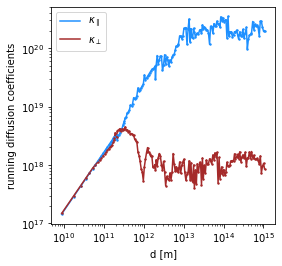

In [7]:
df = pd.read_pickle("data/data_sim.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
dimensions = 3
sta = rw.Statistics(df_time_evolution_observer, dimensions)
errors = False
df_kappas = sta.plot_diffusion_coefficients(errors)

/home/patrick/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


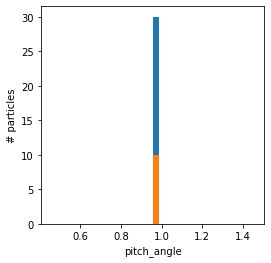

In [8]:
bins = 30
file_name = None
df_kappas = sta.plot_distribution('pitch_angle', -1, bins, file_name)

In [9]:
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.955393,-1.0,0.0
1,0.0,1.0,8.660254e+09,2.811121e+09,3.030313e+09,2.886438e+09,0.050008,0.955393,-1.0,2.0
2,0.0,2.0,1.732051e+10,5.467253e+09,6.197358e+09,5.772877e+09,0.100016,0.955393,-1.0,2.0
3,0.0,3.0,2.598076e+10,7.961752e+09,9.493216e+09,8.659315e+09,0.150024,0.955393,-1.0,2.0
4,0.0,4.0,3.464101e+10,1.028838e+10,1.290965e+10,1.154575e+10,0.200032,0.955393,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
1685,9.0,147176.0,1.277571e+15,-5.233770e+10,-6.520518e+11,-4.693214e+13,316.453308,0.955393,-1.0,2.0
1686,9.0,156486.0,1.360042e+15,3.701330e+11,-1.159353e+12,-4.619340e+13,426.193481,0.955393,-1.0,2.0
1687,9.0,166385.0,1.447731e+15,3.602685e+11,-7.861174e+11,-4.470150e+13,222.779160,0.955393,-1.0,2.0
1688,9.0,176910.0,1.540966e+15,-3.832256e+11,-5.457413e+11,-5.164157e+13,228.029480,0.955393,-1.0,2.0


In [10]:
tra = Trajectory(df_time_evolution_observer, dimensions)
particle_ids = tra.get_particle_ids()
nr_steps = 100
tra.plot_trajectory('x', 'y', 'd', particle_ids[0], nr_steps, None)
tra.plot_trajectory('d', 'z', 'd', particle_ids[0], nr_steps, None)

NameError: name 'Trajectory' is not defined

TypeError: object of type 'float' has no len()